In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

First, we define some functions for computing the output of the multilayer perceptron.

In [2]:
def softmax(x):
    '''
    Input
         x: a vector in ndarray format, 
            typically the raw score of prediction.
    Output 
         a vector in ndarray format,
         typically representing the predicted class probability.
    '''
    res = np.exp(x-np.max(x))
    return res/np.sum(res)

def cross_entropy(y, p):
    '''
    Input
        y: an int representing the class label
        p: a vector in ndarray format showing the predicted
           probability of each class.
           
    Output
        the cross entropy loss. 
    '''
    log_likelihood = -np.log(p)
    return log_likelihood[y]

def relu(x):
    '''
    Input
        x: a vector in ndarray format
    Output
        a vector in ndarray format,
        representing the ReLu activation of x.
    '''
    return np.maximum(x, 0)

def check_inf_norm(x,x_new,eps):
    return np.all(abs(x-x_new)<=eps+1e-8)

Next, we define the structure and some utility functions of our multi-layer perceptron.

In [32]:
class MultiLayerPerceptron():
    '''
    This class defines the multi-layer perceptron we will be using
    as the attack target.
    
    '''
    def __init__(self):
        self.eps = 0.1
    
    def load_params(self, params):
        '''
        This method loads the weights and biases of a trained model.
        '''
        self.W1 = params["fc1.weight"]
        self.b1 = params["fc1.bias"]
        self.W2 = params["fc2.weight"]
        self.b2 = params["fc2.bias"]
        self.W3 = params["fc3.weight"]
        self.b3 = params["fc3.bias"]
        self.W4 = params["fc4.weight"]
        self.b4 = params["fc4.bias"]
        
    def set_attack_budget(self, eps):
        '''
        This method sets the maximum L_infty norm of the adversarial
        perturbation.
        '''
        self.eps = eps
        
    def forward(self, x):
        '''
        This method finds the predicted probability vector of an input
        image x.
        
        Input
            x: a single image vector in ndarray format
        Ouput
            a vector in ndarray format representing the predicted class
            probability of x.
            
        Intermediate results are stored as class attributes.
        You might need them for gradient computation.
        '''
        W1, W2, W3, W4 = self.W1, self.W2, self.W3, self.W4
        b1, b2, b3, b4 = self.b1, self.b2, self.b3, self.b4
        
        self.z1 = np.matmul(x,W1)+b1
        self.h1 = relu(self.z1)
        self.z2 = np.matmul(self.h1,W2)+b2
        self.h2 = relu(self.z2)
        self.z3 = np.matmul(self.h2,W3)+b3
        self.h3 = relu(self.z3)
        self.z4 = np.matmul(self.h3,W4)+b4
        self.p = softmax(self.z4)
        
        return self.p
        
    def predict(self, x):
        '''
        This method takes a single image vector x and returns the 
        predicted class label of it.
        '''
        res = self.forward(x)
        return np.argmax(res)
    
    def gradient(self,x,y):
        ''' 
        This method finds the gradient of the cross-entropy loss
        of an image-label pair (x,y) w.r.t. to the image x.
        
        Input
            x: the input image vector in ndarray format
            y: the true label of x
            
        Output
            a vector in ndarray format representing
            the gradient of the cross-entropy loss of (x,y)
            w.r.t. the image x.
        '''
        
        #######################################
        y_onehot = self.onehot(y)
        self.forward(x)
        dLz4=self.p-y_onehot
        dz4h3=self.W4.T
        dh3z3=np.diag(1*(self.h3>0))
        dz3h2=self.W3.T
        dh2z2=np.diag(1*(self.h2>0))
        dz2h1=self.W2.T
        dh1z1=np.diag(1*(self.h1>0))
        dz1x=self.W1.T
        
        dLx=np.linalg.multi_dot([dLz4,dz4h3,dh3z3,dz3h2,dh2z2,dz2h1,dh1z1,dz1x])
        return dLx
        #######################################
        
    def onehot(self,y):
        y_onehot = np.zeros((10,))
        y_onehot[y]=1
        return y_onehot
        
    
    def attack(self,x,y,eps_max):
        '''
        This method generates the adversarial example of an
        image-label pair (x,y).
        
        Input
            x: an image vector in ndarray format, representing
               the image to be corrupted.
            y: the true label of the image x.
            
        Output
            a vector in ndarray format, representing
            the adversarial example created from image x.
        '''
        
        #######################################
        x_new = x + eps_max*(np.sign(self.gradient(x,y)))
        # white 1, black 0 as limit
        x_new[x_new<0] = 0
        x_new[x_new>1] = 1
        #######################################
        
        return x_new
    def check_inf_norm(self,x,x_new,eps):
        return np.all(abs(x-x_new)<=eps+1e-8)

    def new_attack(self,x,y,eps_max):
        small_eps = eps_max/5
        x_prev = x
        #count = 0
        while True:
            x_new = x_prev + small_eps*(np.sign(self.gradient(x_prev,y)))
            if not self.check_inf_norm(x,x_new,eps_max):
                #print("count = {}".format(count))
                break
            x_prev = x_new
            #count = count + 1
        x_prev[x_prev<0] = 0
        x_prev[x_prev>1] = 1
        return x_prev

Now, let's load the pre-trained model and the test data.

In [33]:
X_test = np.load("./data/X_test.npy")
Y_test = np.load("./data/Y_test.npy")

params = {}
param_names = ["fc1.weight", "fc1.bias",
               "fc2.weight", "fc2.bias",
               "fc3.weight", "fc3.bias",
               "fc4.weight", "fc4.bias"]

for name in param_names:
    params[name] = np.load("./data/"+name+'.npy')
    
clf = MultiLayerPerceptron()
clf.load_params(params)

Check if the image data are loaded correctly. Let's visualize the first image in the data set.

This is an image of Number 7


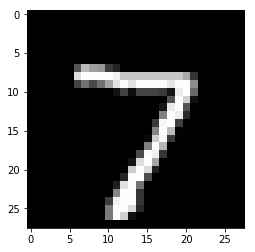

In [7]:
x, y = X_test[0], Y_test[0]
print ("This is an image of Number", y)
pixels = x.reshape((28,28))
plt.imshow(pixels,cmap="gray")

Check if the model is loaded correctly. The test accuracy should be 97.6%

In [12]:
nTest = 1000
Y_pred = np.zeros(nTest)
for i in range(nTest):
    x, y = X_test[i], Y_test[i]
    Y_pred[i] = clf.predict(x)
acc = np.sum(Y_pred == Y_test[:nTest])*1.0/nTest
print ("Test accuracy is", acc)

Test accuracy is 0.976


# FGSM

Have fun!

This is an image of Number 7
True


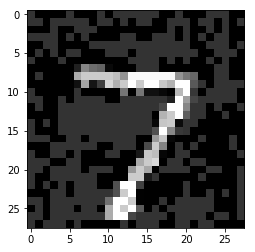

In [45]:
x, y = X_test[0], Y_test[0]
eps_max = 0.2
x_white = clf.attack(x,y,eps_max)
#print(x_white)
print ("This is an image of Number", y)
print(check_inf_norm(x,x_white,eps_max))
pixels = x_white.reshape((28,28))
plt.imshow(pixels,cmap="gray")

In [46]:
nTest = 1000
Y_pred = np.zeros(nTest)
for i in range(nTest):
    x, y = X_test[i], Y_test[i]
    x_white = clf.attack(x,y,eps_max)
    Y_pred[i] = clf.predict(x_white)
acc = np.sum(Y_pred == Y_test[:nTest])*1.0/nTest
print ("Test accuracy is", acc)

Test accuracy is 0.003


# new_attack

True
This is an image of Number 7


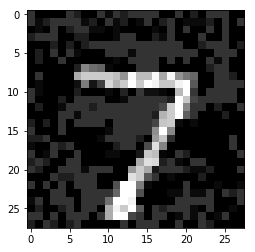

In [47]:
x, y = X_test[0], Y_test[0]
#eps_max = 0.1
x_white1 = clf.new_attack(x,y,eps_max)
print(check_inf_norm(x,x_white1,eps_max))
print ("This is an image of Number", y)
pixels = x_white1.reshape((28,28))
plt.imshow(pixels,cmap="gray")

In [48]:
nTest = 1000
Y_pred = np.zeros(nTest)
for i in range(nTest):
    x, y = X_test[i], Y_test[i]
    x_white1 = clf.new_attack(x,y,eps_max)
    Y_pred[i] = clf.predict(x_white1)
acc = np.sum(Y_pred == Y_test[:nTest])*1.0/nTest
print ("Test accuracy is", acc)

Test accuracy is 0.001
